## What is CliMT?
https://climt.readthedocs.io/en/latest/index.html
Climate Modelling and Diagnostics Toolkit
"a Python based library which provides a modular and intuitive approach to writing numerical models of the climate system. CliMT provides state-of-the art components and an easy-to-use interface to allow writing research quality models without the hassle of modifying Fortran code."

Like the Met Office's Unified Model, the majority of climate models are written in Fortran or C. This is great for performance but it is difficult for researchers to edit and change model configurations. The key benefit of CliMT is that the user can more easily build up complex models, change configurations and swap in various components. 

CliMT is written in Python, which is commonly used for climate model data analysis, allowing the modelling and analysis to be integrated. This opens up more doors for analysis methods that combine statistics or machine learning with the physics. An example of this is probabilistic Bayesian inference which combines a known model with observations to infer latent variables, which can then be used in other aspects of the model.

CliMT makes use of modules which can be built up to create more and more complex models, without the need for the user to rewrite code at each stage. To do this, it uses Sympl, A System for Modelling Planets, which is designed for writing modular Earth system and planetary models, making them easily readable and understandable. 


https://climt.readthedocs.io/en/latest/quickstart.html and https://sympl.readthedocs.io/en/latest/quickstart.html#quickstart
says the essential aspects are:

1. Initialise components: 
    * Initialize model components, providing configuration information
    * Use `Wrapper` components to modify the behaviour of any components if necessary.
    
2. Initialise state:
    * Set up grid
    * Create a state dictionary using `get_default_state`
    * Use `TendencyStepper` to collect all `TendencyComponent` components into a component that can step the model state forward in time
 
3. Main loop to step forward in time and run the components. At each iteration:
    * Call `DiagnosticComponent` to compute any derived quantities from prognostic quantities or provide forcing quantities at a given time step.
    * Call `Stepper` components and get a new state dictionary with the updated model quantities and any diag- nostics. Update the initial model state with diagnostics.
    * Call `TendencyStepper` and get a new state dictio- nary with the updated model quantities and any diagnostics. Update the initial model state with diagnostics.
    * Call any `Monitor` components to store the initial model state (e.g. store to disk, display in real time, send over the network).



## 0. Imports

In [34]:
import climt
import sympl
import matplotlib.pyplot as plt
import numpy as np

## 1. Initialise components.

Components represent the physical processes. Examples include: convection, radiation, surface, dynamical core, ice processes, ...
https://climt.readthedocs.io/en/latest/components.html#component-list

They take in inputs from the model state and return outputs ("tendencies") and diagnostics.

In [49]:
radiation = climt.GrayLongwaveRadiation()
convection = climt.DryConvectiveAdjustment()
simple_physics = sympl.TimeDifferencingWrapper(climt.SimplePhysics())

We will start with 3 components: longwave radiation, convection and a simple physics component for the boundary layer, following the setup in the paper https://www.geosci-model-dev.net/11/3781/2018/gmd-11-3781-2018.pdf. 

You can put in arguments to these components, but for now let's keep these at the default values (chosen to be sensible for the Earth's system). I'll start with a 1D example, in height, by setting up the grid with 10 points in the vertical.

Here we can use wrappers if required. These are used to change the inputs or outputs of a component to make it apparently work in a different way. Examples include the `TimeDifferencingWrapper` which provides the output of the components as time tendencies by using a finite diference scheme. We use this on the `SimplePhysics` component because we will be using a spectral dynamical core, which doesn't work well with components that step forward the model in grid space.  We could also choose wrappers such as the `UpdateFrequencyWrapper` which can be used to call components less frequently than the model timestep specified, such as the radiative scheme which can be called every hour, rather than every 10 minutes.
https://climt.readthedocs.io/en/latest/configuration.html

## 2. Initialise state

a) Create a grid, which is a dictionary of dimensions
Here we can define the size of the grid. We will start with a 1D grid, an atmospheric column of air. 

In [50]:
grid = climt.get_grid(nx=18, ny=18, nz=10)
print(*grid,sep='\n')

atmosphere_hybrid_sigma_pressure_a_coordinate_on_interface_levels
atmosphere_hybrid_sigma_pressure_b_coordinate_on_interface_levels
surface_air_pressure
time
air_pressure
air_pressure_on_interface_levels
longitude
latitude
height_on_ice_interface_levels


b) Create a state dictionary using `get_default_state`. This gives a dictionary of quantities that are inputs or outputs to the components. It also sets up the initial conditions. 

In [63]:
state = climt.get_default_state([radiation, convection, simple_physics], grid_state=grid)
print(*state,sep='\n')

atmosphere_hybrid_sigma_pressure_a_coordinate_on_interface_levels
atmosphere_hybrid_sigma_pressure_b_coordinate_on_interface_levels
surface_air_pressure
time
air_pressure
air_pressure_on_interface_levels
longitude
latitude
height_on_ice_interface_levels
longwave_optical_depth_on_interface_levels
air_temperature
surface_temperature
specific_humidity
northward_wind
eastward_wind
surface_specific_humidity


In [64]:
state['air_temperature']

<xarray.DataArray 'air_temperature' (mid_levels: 10, lat: 18, lon: 18)>
array([[[290., 290., ..., 290., 290.],
        [290., 290., ..., 290., 290.],
        ...,
        [290., 290., ..., 290., 290.],
        [290., 290., ..., 290., 290.]],

       [[290., 290., ..., 290., 290.],
        [290., 290., ..., 290., 290.],
        ...,
        [290., 290., ..., 290., 290.],
        [290., 290., ..., 290., 290.]],

       ...,

       [[290., 290., ..., 290., 290.],
        [290., 290., ..., 290., 290.],
        ...,
        [290., 290., ..., 290., 290.],
        [290., 290., ..., 290., 290.]],

       [[290., 290., ..., 290., 290.],
        [290., 290., ..., 290., 290.],
        ...,
        [290., 290., ..., 290., 290.],
        [290., 290., ..., 290., 290.]]])
Dimensions without coordinates: mid_levels, lat, lon
Attributes:
    units:    degK

In [52]:
state['eastward_wind'].values[:] = np.random.randn(*state['eastward_wind'].shape)
state['surface_temperature'].values[:] = np.random.randn(*state['surface_temperature'].shape)



## 3. Run main loop

Before we run the loop, lets take a look at what some of the components do. For example, we'll start with the radiation component, which returns:
* `tendencies`: the local rate of change of a quantity with time at a given point in space. https://encyclopedia2.thefreedictionary.com/tendency
* `diagnostics`: variables not directly tracked by the model itself, that are instead derived from other variables. https://en.wikipedia.org/wiki/Prognostic_variable
In CliMT, these outputs are dictionaries. We can check the properties using `tendency_properties` and `diagnostic_properties`, which tells us the names, dimensions and units of the returned dictionaries. 

In [53]:
print("RADIATION TENDENCIES:", radiation.tendency_properties, sep='\n ')
print("RADIATION DIAGNOSTICS:", radiation.diagnostic_properties, sep='\n ')

RADIATION TENDENCIES:
 {'air_temperature': {'units': 'degK s^-1'}}
RADIATION DIAGNOSTICS:
 {'downwelling_longwave_flux_in_air': {'dims': ['interface_levels', '*'], 'units': 'W m^-2', 'alias': 'lw_down'}, 'upwelling_longwave_flux_in_air': {'dims': ['interface_levels', '*'], 'units': 'W m^-2', 'alias': 'lw_up'}, 'longwave_heating_rate': {'dims': ['mid_levels', '*'], 'units': 'degK day^-1'}}


To calculate these tendencies and diagnostics, we run `radiation` on the state.

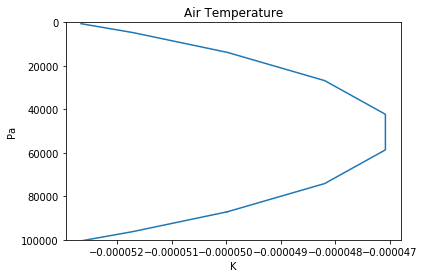

In [54]:
tendencies, diagnostics = radiation(state)

plt.plot(tendencies['air_temperature'].values.flatten(), 
         state['air_pressure'].values.flatten() )
ax = plt.gca()
ax.axes.invert_yaxis(), ax.set_ylim(1e5, 100.), 
ax.set_xlabel('K'), ax.set_ylabel('Pa'), ax.set_title('Air Temperature');

In [55]:
state.update(diagnostics)



Now let's check the convection scheme. This requires a second argument, a timestep, to step forward in time. 

In [56]:
print("CONVECTION TENDENCIES:", convection.tendency_properties, sep='\n ')
print("CONVECTION DIAGNOSTICS:", convection.diagnostic_properties, sep='\n ')

AttributeError: 'DryConvectiveAdjustment' object has no attribute 'tendency_properties'

In [57]:
from datetime import timedelta
timestep = timedelta(minutes=200)

In [58]:
convection(state, timestep)

({}, {'air_temperature': <xarray.DataArray (mid_levels: 10, lat: 18, lon: 18)>
  array([[[290., 290., ..., 290., 290.],
          [290., 290., ..., 290., 290.],
          ...,
          [290., 290., ..., 290., 290.],
          [290., 290., ..., 290., 290.]],
  
         [[290., 290., ..., 290., 290.],
          [290., 290., ..., 290., 290.],
          ...,
          [290., 290., ..., 290., 290.],
          [290., 290., ..., 290., 290.]],
  
         ...,
  
         [[290., 290., ..., 290., 290.],
          [290., 290., ..., 290., 290.],
          ...,
          [290., 290., ..., 290., 290.],
          [290., 290., ..., 290., 290.]],
  
         [[290., 290., ..., 290., 290.],
          [290., 290., ..., 290., 290.],
          ...,
          [290., 290., ..., 290., 290.],
          [290., 290., ..., 290., 290.]]])
  Dimensions without coordinates: mid_levels, lat, lon
  Attributes:
      units:    degK,
  'specific_humidity': <xarray.DataArray (mid_levels: 10, lat: 18, lon: 18)>
  arra

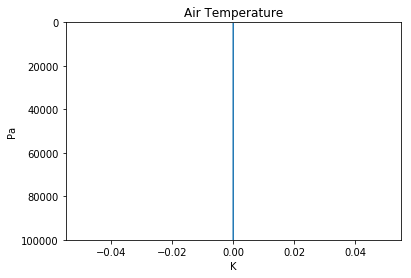

In [66]:
tendencies, diagnostics = convection(state, timestep)
plt.plot(diagnostics['specific_humidity'].values.flatten(), 
         state['air_pressure'].values.flatten() )
ax = plt.gca()
ax.axes.invert_yaxis(), ax.set_ylim(1e5, 100.), 
ax.set_xlabel('K'), ax.set_ylabel('Pa'), ax.set_title('Air Temperature');


In [67]:
tendencies['air_temperature'].dims

KeyError: 'air_temperature'

We could also have checked what the associated tendencies and diagnostics are using the `tendency_properties` and `diagnostic_properties`. This also tells us their names, dimensions and units.

In [68]:
print("RADIATION:")
print("TENDENCIES:", radiation.tendency_properties, sep='\n ')
print("DIAGNOSTICS:", radiation.diagnostic_properties, sep='\n ')

RADIATION:
TENDENCIES:
 {'air_temperature': {'units': 'degK s^-1'}}
DIAGNOSTICS:
 {'downwelling_longwave_flux_in_air': {'dims': ['interface_levels', '*'], 'units': 'W m^-2', 'alias': 'lw_down'}, 'upwelling_longwave_flux_in_air': {'dims': ['interface_levels', '*'], 'units': 'W m^-2', 'alias': 'lw_up'}, 'longwave_heating_rate': {'dims': ['mid_levels', '*'], 'units': 'degK day^-1'}}


In [69]:
print("SIMPLE PHYSICS:")
print("TENDENCIES:", simple_physics.tendency_properties, sep='\n ')
print("DIAGNOSTICS:", simple_physics.diagnostic_properties, sep='\n ')

SIMPLE PHYSICS:
TENDENCIES:
 {'air_temperature': {'units': 'degK s^-1'}, 'specific_humidity': {'units': 'kg/kg s^-1'}, 'northward_wind': {'units': 'm s^-1 s^-1'}, 'eastward_wind': {'units': 'm s^-1 s^-1'}}
DIAGNOSTICS:
 {'stratiform_precipitation_rate': {'dims': ['*'], 'units': 'm s^-1'}, 'surface_upward_latent_heat_flux': {'dims': ['*'], 'units': 'W m^-2'}, 'surface_upward_sensible_heat_flux': {'dims': ['*'], 'units': 'W m^-2'}}


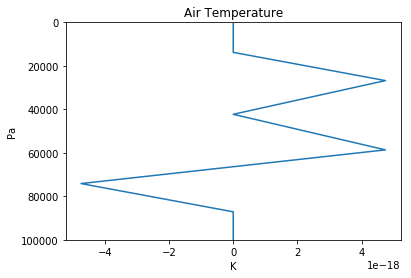

In [70]:
simple_physics.tendency_properties
tendencies, diagnostics = simple_physics(state, timestep)
plt.plot(tendencies['air_temperature'].values.flatten(), 
         state['air_pressure'].values.flatten() )
ax = plt.gca()
ax.axes.invert_yaxis(), ax.set_ylim(1e5, 100.), 
ax.set_xlabel('K'), ax.set_ylabel('Pa'), ax.set_title('Air Temperature');

In [71]:
from datetime import timedelta
timestep = timedelta(hours=1)

In [72]:
state.update(diagnostics)

In [76]:
tendencies, diagnostics = radiation(state)
state.update(diagnostics)
print(tendencies['air_temperature'])
state['air_temperature']+=tendencies['air_temperature']

tendencies, diagnostics = convection(state, timestep)
state.update(diagnostics)
print(diagnostics['specific_humidity'])


tendencies, diagnostics = simple_physics(state, timestep)
state.update(diagnostics)
print(tendencies['air_temperature'])
state['air_temperature']+=tendencies['air_temperature']
state['specific_humidity']+=tendencies['specific_humidity']


<xarray.DataArray (mid_levels: 10, lat: 18, lon: 18)>
array([[[-8.767270e-06, -8.767270e-06, ..., -8.767270e-06, -8.767270e-06],
        [-8.767270e-06, -8.767270e-06, ..., -8.767270e-06, -8.767270e-06],
        ...,
        [-8.767270e-06, -8.767270e-06, ..., -8.767270e-06, -8.767270e-06],
        [-8.767270e-06, -8.767270e-06, ..., -8.767270e-06, -8.767270e-06]],

       [[-9.610219e-06, -9.610219e-06, ..., -9.610219e-06, -9.610219e-06],
        [-9.610219e-06, -9.610219e-06, ..., -9.610219e-06, -9.610219e-06],
        ...,
        [-9.610219e-06, -9.610219e-06, ..., -9.610219e-06, -9.610219e-06],
        [-9.610219e-06, -9.610219e-06, ..., -9.610219e-06, -9.610219e-06]],

       ...,

       [[-3.458934e-05, -3.458934e-05, ..., -3.458934e-05, -3.458934e-05],
        [-3.458934e-05, -3.458934e-05, ..., -3.458934e-05, -3.458934e-05],
        ...,
        [-3.458934e-05, -3.458934e-05, ..., -3.458934e-05, -3.458934e-05],
        [-3.458934e-05, -3.458934e-05, ..., -3.458934e-05, -3.458

In [77]:
component = sympl.ImplicitTendencyComponentComposite(radiation, convection, simple_physics)
?component

TypeError: Component should be of type (<class 'sympl._core.base_components.TendencyComponent'>, <class 'sympl._core.base_components.ImplicitTendencyComponent'>) but is type <class 'climt._components.dry_convection.component.DryConvectiveAdjustment'>

In [61]:
rad_stepper = sympl.TendencyStepper(component)
rad_stepper(state, timestep)

NotImplementedError: 

We can run all these steps together in timestepper, such as the AdamsBathforth stepper or the GFS Dynamical Core stepper. 


In [42]:
dycore = climt.GFSDynamicalCore(
        [simple_physics, radiation,
         convection], number_of_damped_levels=5
    )
    

In [43]:
#dycore

In [48]:
state.keys()

dict_keys(['atmosphere_hybrid_sigma_pressure_a_coordinate_on_interface_levels', 'atmosphere_hybrid_sigma_pressure_b_coordinate_on_interface_levels', 'surface_air_pressure', 'time', 'air_pressure', 'air_pressure_on_interface_levels', 'longitude', 'latitude', 'height_on_ice_interface_levels', 'longwave_optical_depth_on_interface_levels', 'air_temperature', 'surface_temperature', 'specific_humidity', 'eastward_wind', 'northward_wind', 'cloud_base_mass_flux', 'surface_specific_humidity'])

In [45]:
diagnostics, new_state = dycore(state, timestep)
state.update(diagnostics)
state.update(new_state)
state['time'] += timestep


InvalidStateError: Missing input quantity divergence_of_wind

In [125]:
for step in range(100):
    diagnostics, new_state = dycore(state, timestep)
    state.update(new_state)
    state['time'] += timestep
    #print(state['time'], ': ', state['air_temperature'].max().values)
    observe_temp = state['air_temperature'][1,0,0]

InvalidStateError: Missing input quantity divergence_of_wind

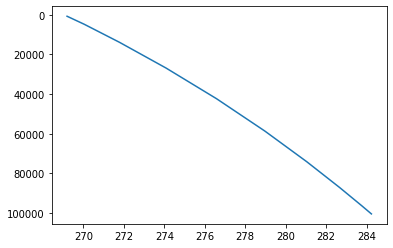

In [41]:
import matplotlib.pyplot as plt 
plt.plot(state['air_temperature'][:,0,0],state['air_pressure'][:,0,0])
plt.gca().invert_yaxis()